In [2]:
import pandas as pd
import numpy as np
import gc, warnings
warnings.filterwarnings('ignore')

# Overview
What is this kernel about?
* No predictions to make 
* No features to create

We will load competition data and look closer on it. We will try to understand what we have in our hands and how we can work with it.
* * *

We have 3 types of products in the test set:

Products that have some "sales history" - these are (let's call it) NORMAL items - we can use lags features/price history/etc -> all possible features for normal time series data.

Items that have some history but we do not have any "item/shop" match in the train data -> good example here -> "digital" items. You can find that only one shop is selling digital items, but we cannot be so sure about other items/shop pairs. **Probably we can find items that we don't need to do any prediction and set 0 for them (if not -> mark it as normal items and do normal prediction).**

Items that we have no history at all. There are three options -
3.1. This is a new item -> NEW RELEASE (we don't need time series features) -> **we need to predict future sales based on the type of the product and shop overall "specialty"** (how many similar products were sold there) and other "categorical" features and time series features for item category but NOT for certain Item.
3.2. This is an old item -> OLD RELEASE, but nobody wants to buy it. Probably you can do some FE from the name of the item or category. These are totally random sales -> that depend only "how far Venus from Mars in 3/4 part of June in the year 1968" -> it is very hard to do predictions here, but we are lucky that most of such cases are close to 0.
3.3 Products that were not included in the train set but have some history. It is hard to recognize such products -> so I decided to remove this option.

Hope it helps. I wish to say more, but I don't want to ruin LB (still 7 moths to go).

 ## Load train data
 * * *

In [5]:
sale_train = pd.read_csv('./data/sales_train.csv')

We can view basic DafaFrame information. 

As you can see, we do not have broken and nan data that is good.

In [6]:
print("----------Top-5- Record----------")
print(sale_train.head(5))
print("-----------Information-----------")
print(sale_train.info())
print("-----------Data Types-----------")
print(sale_train.dtypes)
print("----------Missing value-----------")
print(sale_train.isnull().sum())
print("----------Null value-----------")
print(sale_train.isna().sum())
print("----------Shape of Data----------")
print(sale_train.shape)

----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
-----------Data Types-----------
date               object
date_block_num  

We have duplicated rows, but I don't think that it is a mistake.

It could be different sales methods or client type, etc.

You can remove it, but I really don't believe that 6 rows of 3m can make the difference.

In [7]:
print('Number of duplicates:', len(sale_train[sale_train.duplicated()]))

Number of duplicates: 6


I can advise downcasting your DataFrame. It will save you some memory, and believe me you will need all memory possible.

In our case from 134.4+ MB, we went to 61.6+ MB

Not a great deal right now but such approach works with bigger DF also.

#### please see this two links for more tips (I stole that downcast basic snippet from anqitu)))
* https://www.kaggle.com/anqitu/feature-engineer-and-model-ensemble-top-10
* https://www.kaggle.com/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask

In [8]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

sale_train = downcast_dtypes(sale_train)
print(sale_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


## 1.1 Item_id
* * *
### Lets group data by item_id and date_block_num and look closer on it.


In [9]:
sales_by_item_id = sale_train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

### Simple graph
What this graph is telling us. Basically nothing.)) I only see that train data has many old products (degradation line) and many 1c products are seasonal and probably release date depended.

#### I'm not very good with graphs and presentations - there are better data representation examples:
* https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda
* https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts

<AxesSubplot:>

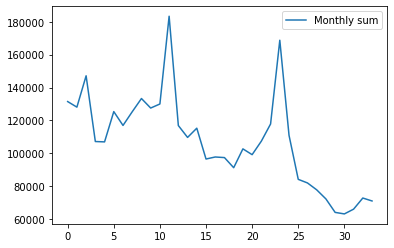

In [10]:
sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")

<AxesSubplot:>

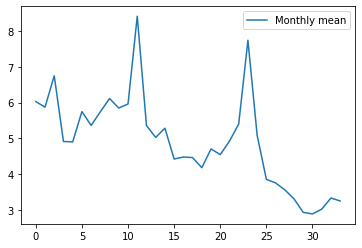

In [11]:
sales_by_item_id.mean()[1:].plot(legend=True, label="Monthly mean")

### Let's see how many products are outdated (no sales for the last 6 months)
12391 of 21807 is a huge number. Probably we can set 0 for all that items and do not make any model prediction.

In [12]:
outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))

Outdated items: 12391


### How many outdated items in test set?
6888 - not much but we have such items

In [14]:
test = pd.read_csv('./data/test.csv')
print('Outdated items in test set:', len(test[test['item_id'].isin(outdated_items['item_id'])]))

Outdated items in test set: 6888


### Outliers by price and sales volume
We will get rid of them later

#### please see lovely kernel made by Denis Larionov (I stole few graphs from there)
* https://www.kaggle.com/dlarionov/feature-engineering-xgboost

Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


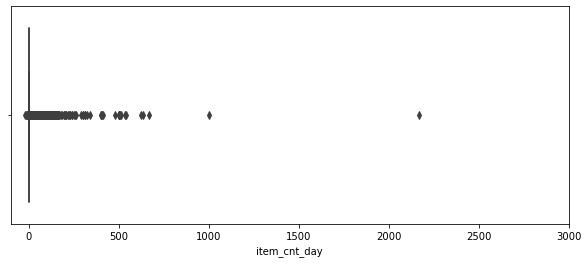

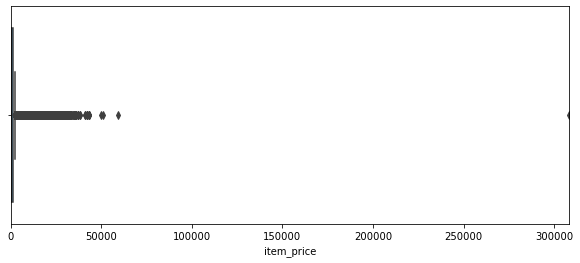

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sale_train['item_cnt_day'])
print('Sale volume outliers:',sale_train['item_id'][sale_train['item_cnt_day']>500].unique())

plt.figure(figsize=(10,4))
plt.xlim(sale_train['item_price'].min(), sale_train['item_price'].max())
sns.boxplot(x=sale_train['item_price'])
print('Item price outliers:',sale_train['item_id'][sale_train['item_price']>50000].unique())

### Possible item_id features:
1. Lags
2. Release date
3. Last month sale
4. Days on sale
5. Neighbors (items with id 1000 and 1001 could be somehow similar - genre, type, release date)

## 1.2 shop_id
* * *
### Lets now group train data by shop_id.
We can see new shops - probably there will be a sales spike (opening event for example).
Apparently closed shops (ill call it "outdated shops")  - no sales for last 6 months.

In [16]:
sales_by_shop_id = sale_train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

for i in range(6,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

for i in range(6,28):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())


Not exists in month 6 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 7 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 8 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 9 [11 20 33 34 36 39 40 48 49]
Not exists in month 10 [11 20 33 34 36 39 40 48 49]
Not exists in month 11 [11 20 33 34 36 39 40 48]
Not exists in month 12 [11 20 33 34 36 39 40 48]
Not exists in month 13 [11 20 33 34 36 39 40 48]
Not exists in month 14 [11 20 33 34 36 48]
Not exists in month 15 [11 20 33 34 36]
Not exists in month 16 [11 20 33 34 36]
Not exists in month 17 [11 20 33 34 36]
Not exists in month 18 [11 20 33 36]
Not exists in month 19 [11 20 36]
Not exists in month 20 [11 20 36]
Not exists in month 21 [11 36]
Not exists in month 22 [11 36]
Not exists in month 23 [11 36]
Not exists in month 24 [11 36]
Not exists in month 25 [36]
Not exists in month 26 [36]
Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]


In our test set we have 5100 sales in really new shop and no "outdated shops" but anyway it is good feature for future.

In [17]:
print('Recently opened shop items:', len(test[test['shop_id']==36]))

Recently opened shop items: 5100


### Possible shop_id features
1. Lags (shop_id/shp_cnt_mth)
2. Opening month (possible  opening sales)
3. Closed Month (possible stock elimination)

## 1.3 Price
* * *
### Possible Price features:
1. Price category (1$/10$/20$/ etc.) - obviously (or not obviously),  items with smaller price have greater volumes
2. Discount and Discount duration
3. Price lag (shows discount)
4. Price correction (rubl/usd pair)
5. Shop Revenue

## 1.4 Dates
* * *
### Possible Date features:
1. Weekends and holidays sales (to correct monthly sales)
2. Number of days in the month (to correct monthly sales)
3. Month number (for seasonal items)

## 1.5 Shop info
* * *
The structure of the shop information is evident.
### Shop City | Shop type | Shop name

In [19]:
shops = pd.read_csv('./data/shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


With a close look we can find out that some shops have duplicated id/name - probably it changed location (within commercial center), or it has a different type (isle sale point), but I decided to merge it.
* 11 => 10
* 1  => 58
* 0  => 57
* 40 => 39

I converted train shop_id to shop_id that is in the test set

In [20]:
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

,shop_name,shop_id,shop_city,shop_type
0,якутск орджоникидзе фран,0,якутск,NO_DATA
1,якутск тц центральный фран,1,якутск,тц
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрькиномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц


### Possible Shop features:
1. Shop City
2. Shop Type

## 1.6 Item info
* * *
Let's see what we can get from this file.

In [22]:
items = pd.read_csv('./data/items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


We can enconde "features" that many items have.

The structure is always the same
### Item name [category feature] (additional feature)
we can split it, and "one hot encode it."

In [23]:
# Ugly code to show the idea
from collections import Counter
from operator import itemgetter
items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

result_1 = Counter(' '.join(items['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature'])

print('Most common aditional features:', result)

Most common aditional features:            feature  count
130   документация    284
131     английская    340
132        русские    399
133       субтитры    400
134            360    465
135          jewel    552
136           xbox    589
137            ps3    611
138        русская   1428
139       цифровая   1995
140             pc   2585
141         версия   3427
1981           box    246
1983            3d    409
1985           dvd    503
1986      digipack    541
1988          фирм    757
1991           mp3    854
1992            cd    871
1993        регион   1849
1994            bd   2320


### Item name correction
For our basic "name feature" it is enough to find identical items (not similar but identical),

In [24]:
print('Unique item names:', len(items['item_name'].unique()))

Unique item names: 22170


In [25]:
import re
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items['item_name'] = items['item_name'].apply(lambda x: name_correction(x))
items.head()

,item_name,item_id,item_category_id,name_1,name_2,name_3
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d
4,коробка,4,40,***КОРОБКА,0,стекло d


In [26]:
print('Unique item names after correction:', len(items['item_name'].unique()))

Unique item names after correction: 18121


### Possible Item features:
1. Item name
2. Encoded aditional feature 

## 1.7 Category info
* * *
The structure here is
### Section name - subsection
we can split it and have two features from one

In [28]:
categories = pd.read_csv('./data/item_categories.csv')
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


### But I did manual feature extraction here to have four features.
Section / Main Category name / Main SubCategory name / Secondary SubCategory name
#### Аксессуары / PS2	/ PS / 2

### Possible Category features
1. Section
2. Main Category name
3. Main SubCategory name 
4. Secondary SubCategory name


## 1.8 Test Set
* * *
The key to my success was the analysis of Test test data.

We have three groups of items:
1. Item/shop pairs that are in train
2. Items without any data
3. Items that are in train

In [29]:
test = pd.read_csv('./data/test.csv')
good_sales = test.merge(sale_train, on=['item_id','shop_id'], how='left').dropna()
good_pairs = test[test['ID'].isin(good_sales['ID'])]
no_data_items = test[~(test['item_id'].isin(sale_train['item_id']))]

print('1. Number of good pairs:', len(good_pairs))
print('2. No Data Items:', len(no_data_items))
print('3. Only Item_id Info:', len(test)-len(no_data_items)-len(good_pairs))
  

1. Number of good pairs: 111404
2. No Data Items: 15246
3. Only Item_id Info: 87550


#### Is it feature? Yes. We need to apply different prediction approach for each type of items in the test set.
####  For example - "No Data Items" - it is more likely classification task.

### Next part will be about data aggregation and feature preparation.
## To be continued...